In [1]:
# -*- coding: utf-8 -*-

"""
Testing pysptk
"""

In [6]:
from __future__ import division, print_function

import os
from shutil import rmtree
import argparse
import glob
import pickle
import time

import numpy as np
from numpy.linalg import norm 
from sklearn.decomposition import PCA
from sklearn.mixture import GMM # sklearn 0.20.0から使えない
from sklearn.preprocessing import StandardScaler
import scipy.signal
import scipy.sparse

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="dark")
plt.rcParams['figure.figsize'] = (16, 5)
from IPython.display import Audio 

import soundfile as sf
import wave 
import pyworld as pw
import librosa.display
import pysptk

from dtw import dtw
import warnings
warnings.filterwarnings('ignore')

In [7]:
def analyse_by_world_with_harverst(x, fs, fftl=1024, shiftms=5.0, minf0=40.0, maxf0=500.0):
    """
    WORLD音声分析合成器で基本周波数F0,スペクトル包絡,非周期成分を求める.
    基本周波数F0についてはharvest法により,より精度良く求める.
    """

    f0, time_axis = pw.harvest(x, fs, f0_floor=minf0, f0_ceil=maxf0, frame_period=shiftms)
    spc = pw.cheaptrick(x, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(x, f0, time_axis, fs, fft_size=fftl)
    
    # 4 Harvest with F0 refinement (using Stonemask)
    """
    frame_period = 5
    _f0, t = pw.harvest(x, fs, frame_period=frame_period)
    f0 = pw.stonemask(x, _f0, t, fs)
    sp = pw.cheaptrick(x, f0, t, fs)
    ap = pw.d4c(x, f0, t, fs)
    """
    
    return f0, spc, ap

def wavread(file):
    """
    wavファイルから音声トラックとサンプリング周波数を抽出する.
    """
    wf = wave.open(file, "r")
    fs = wf.getframerate()
    x = wf.readframes(wf.getnframes())
    x = np.frombuffer(x, dtype= "int16") / 32768.0
    wf.close()
    return x, float(fs)

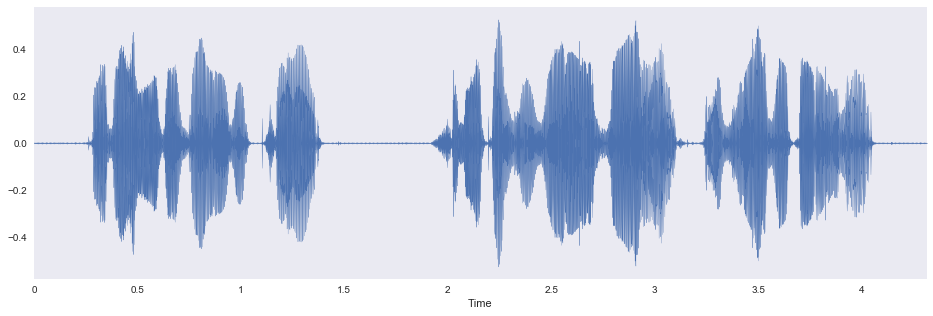

In [8]:
frame_length = 1024
hop_length = 80

x, fs = sf.read('utterance/A01.wav')
assert fs == 16000

librosa.display.waveplot(x, sr=fs)
Audio(x, rate=fs)

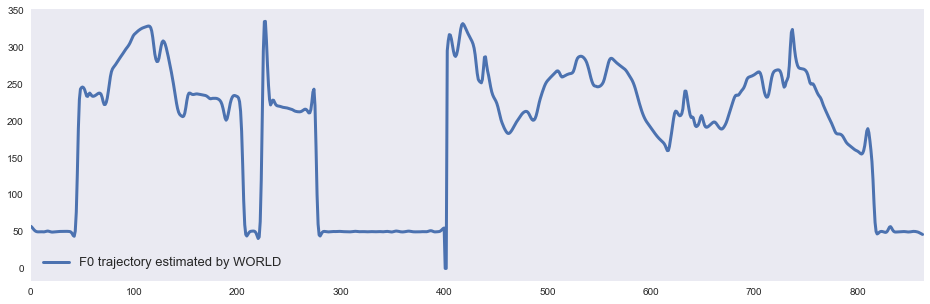

In [12]:
f0, sp, ap = analyse_by_world_with_harverst(x, fs)
plt.plot(f0, linewidth=3, label="F0 trajectory estimated by WORLD")
plt.xlim(0, len(f0))
plt.legend(prop={'size': 13})

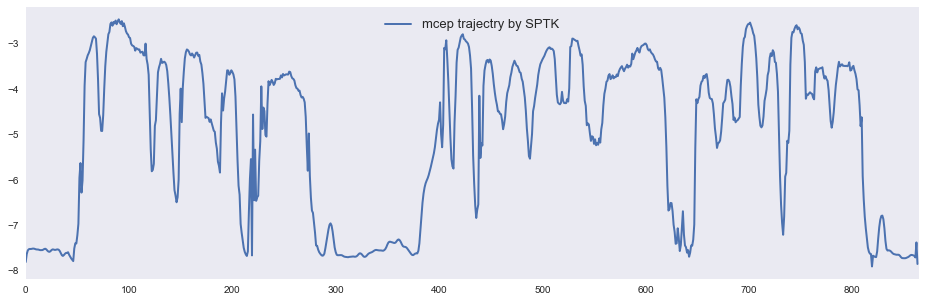

In [13]:
dim = 24
alpha = 0.42
mc = pysptk.sp2mc(sp, dim, alpha)

mc_t = mc.T
plt.plot(mc_t[0], linewidth=2, label="mcep trajectry by SPTK")
plt.xlim(0, len(mc_t[0]))
plt.legend(prop={'size': 13})

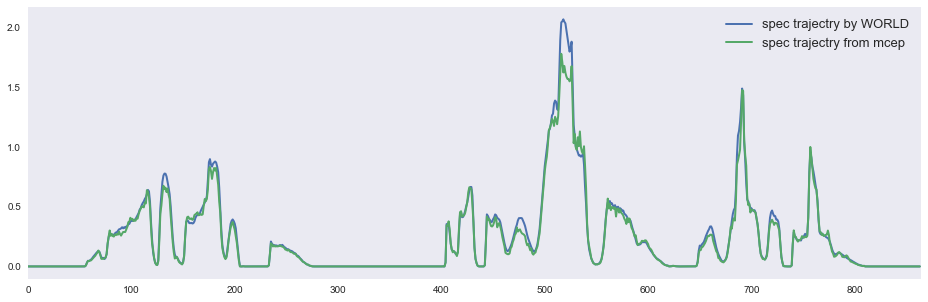

In [14]:
spc = pysptk.mc2sp(mc, alpha, frame_length)

sp_t = sp.T
spc_t = spc.T
plt.plot(sp_t[0], linewidth=2, label="spec trajectry by WORLD")
plt.plot(spc_t[0], linewidth=2, label="spec trajectry from mcep")
plt.xlim(0, len(sp_t[0]))
plt.legend(prop={'size': 13})

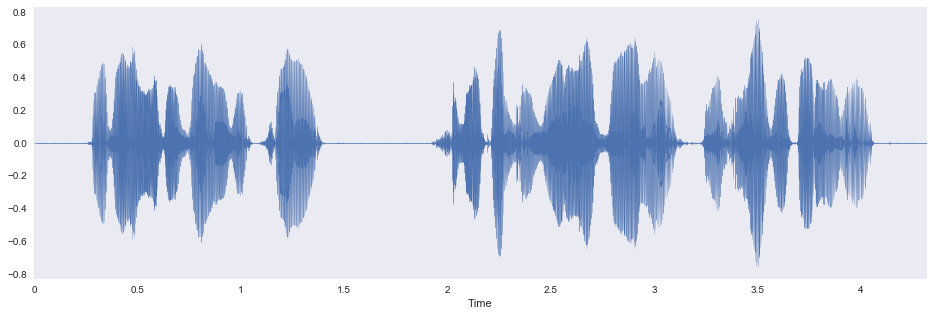

In [15]:
wav = pw.synthesize(f0, spc, ap, fs)

librosa.display.waveplot(wav, sr=fs)
Audio(wav, rate=fs)